# Selection pass fine-tuning results.
Below charts present results of the BERT model fine-tunings. \
For both plain and json data formats, I performed a simple, 15 epoch fine-tuning, \
as well ass 15 epoch fine-tuning with curriculum learning enabled (but without preserving learning rate between new datasets). \
I decided to run the curriculum experiment because json fine-tune had lower accuracy thn the plain text one, and my hypothesis \
was that json data has more "garbage" entries, and so it may benefit from the initial class balancing. \
Sadly, that was not the case.

In [50]:
import wandb
import matplotlib.pyplot as plt
import torch
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [51]:
wandb.login(key='')
hf_token = ''
api = wandb.Api()

project_name = "bert_ft"

runs = api.runs(f"sf-kozlowski-university-of-warsaw/{project_name}")
history = runs[0].history()
history.head()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\gusta\_netrc


,train/learning_rate,train/epoch,train/grad_norm,eval/samples_per_second,eval/f1,_runtime,eval/recall,_timestamp,eval/O_recall,train/loss,train/global_step,eval/B-COUPON_recall,eval/I-COUPON_recall,_step,eval/precision,eval/overall_accuracy,eval/steps_per_second,eval/loss,eval/runtime
0,0.00002,0.018382,6.584771,NaN,NaN,4.139162,NaN,1.742998e+09,NaN,0.6157,20,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
1,0.00002,0.027574,13.877763,NaN,NaN,4.885876,NaN,1.742998e+09,NaN,0.5064,30,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
2,0.00002,0.036765,13.488936,NaN,NaN,5.667565,NaN,1.742998e+09,NaN,0.4425,40,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN
3,0.00002,0.045956,3.769155,NaN,NaN,6.434183,NaN,1.742998e+09,NaN,0.3856,50,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN
4,0.00002,0.091912,4.309347,NaN,NaN,10.213690,NaN,1.742998e+09,NaN,0.3900,100,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN


## Training statistics.

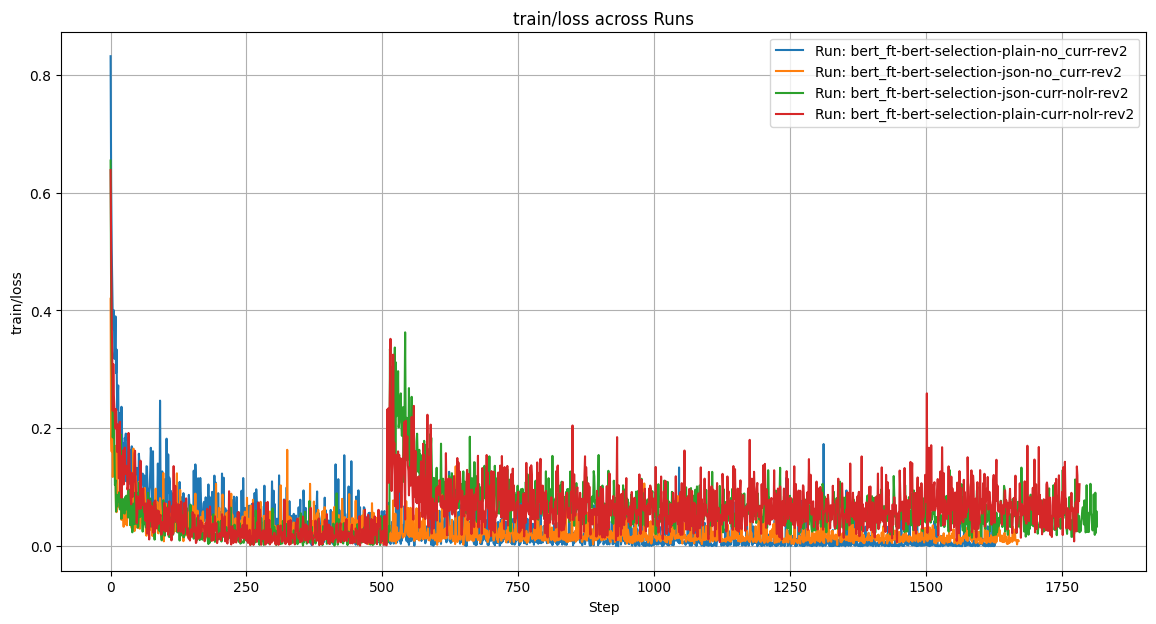

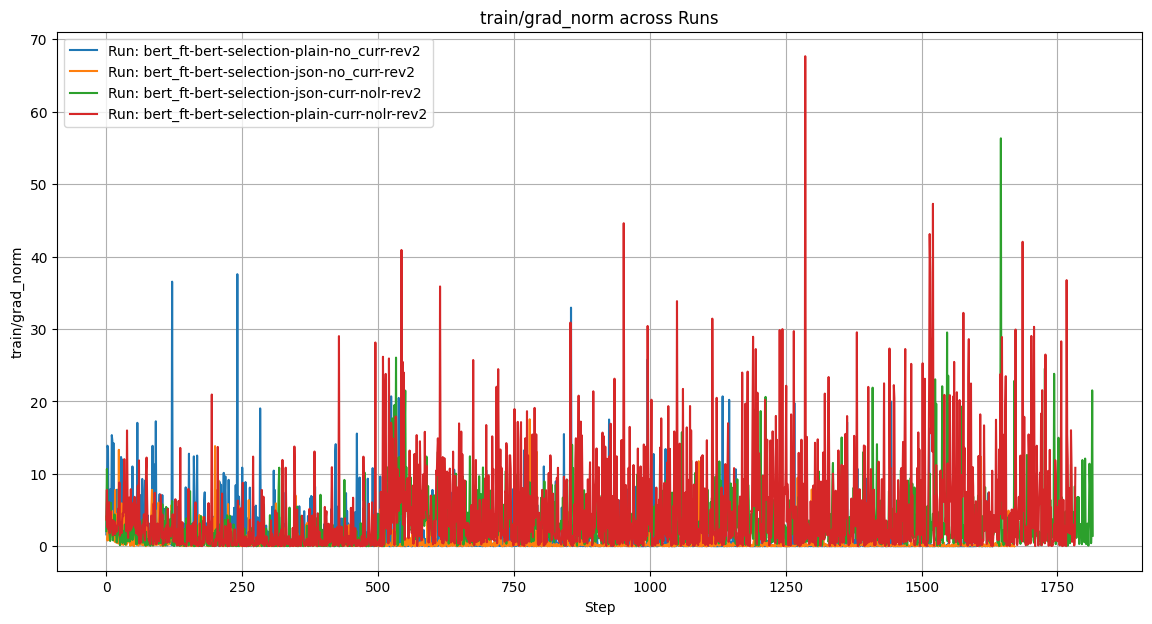

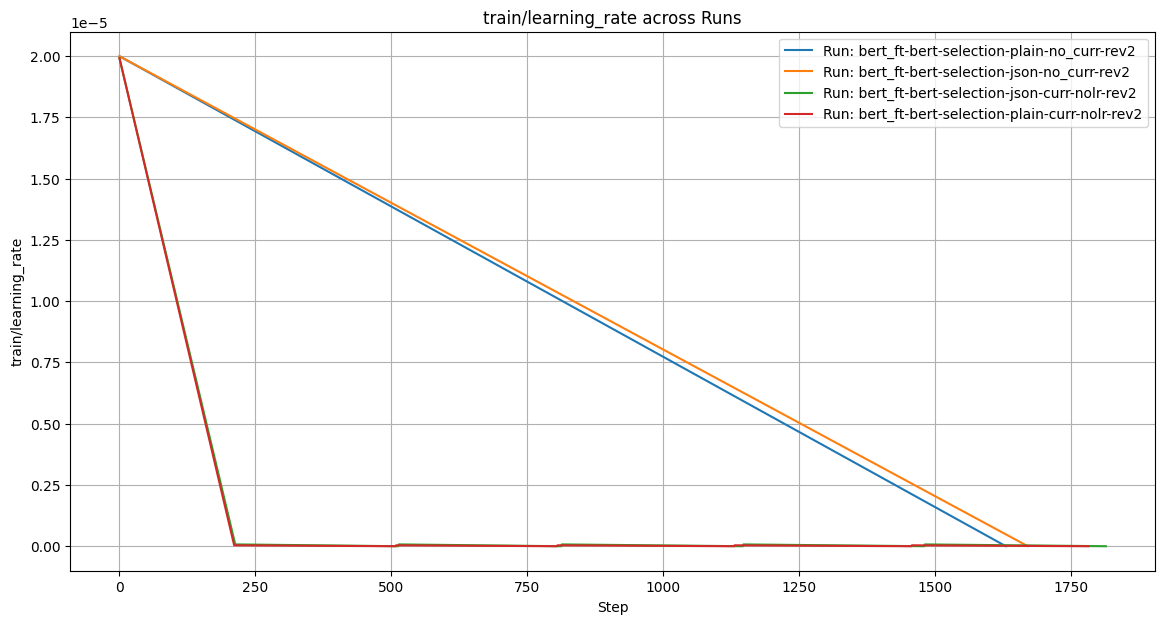

In [52]:
def plot_runs_data(runs, metric):
    plt.figure(figsize=(14, 7))
    for run in runs:
        hist = run.scan_history()
        # Convert to DataFrame
        hist_df = pd.DataFrame(hist)
        if hist_df.empty:
            continue
        if metric in hist_df.columns:
            # Filter out nans
            data = hist_df[metric].dropna()
            labels = list(range(len(data)))
            plt.plot(labels, data, label=f"Run: {run.name}")

    plt.xlabel("Step")
    plt.ylabel(metric)
    plt.title(f"{metric} across Runs")
    plt.legend()
    plt.grid()
    plt.show()

plot_runs_data(runs, "train/loss")
plot_runs_data(runs, "train/grad_norm")
plot_runs_data(runs, "train/learning_rate")

# Evaluation statistics.

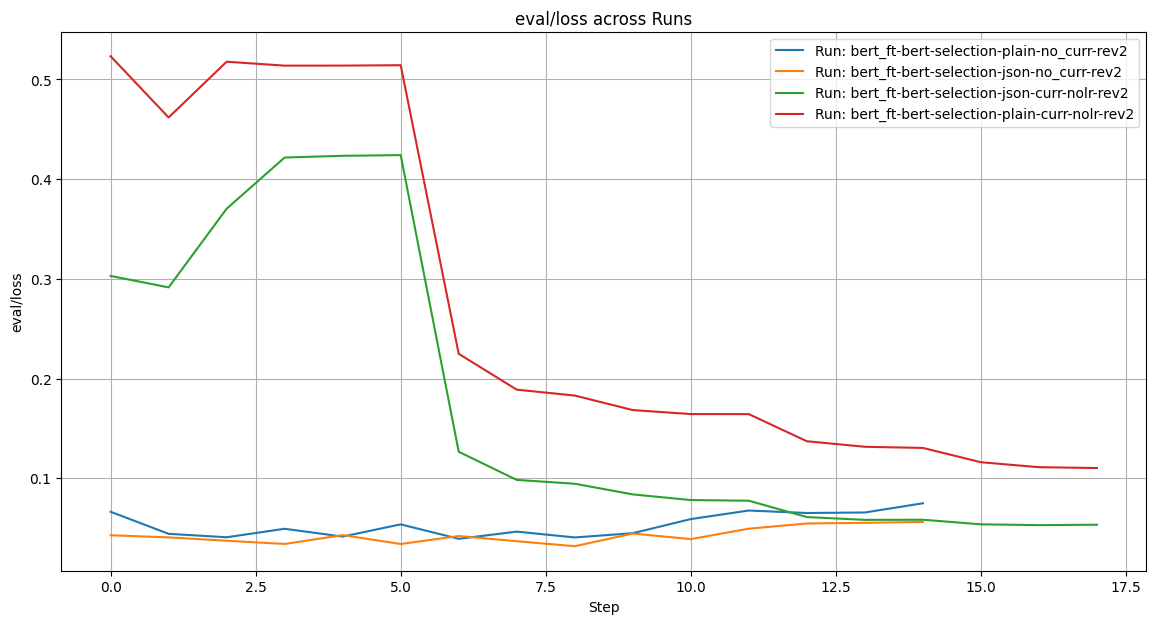

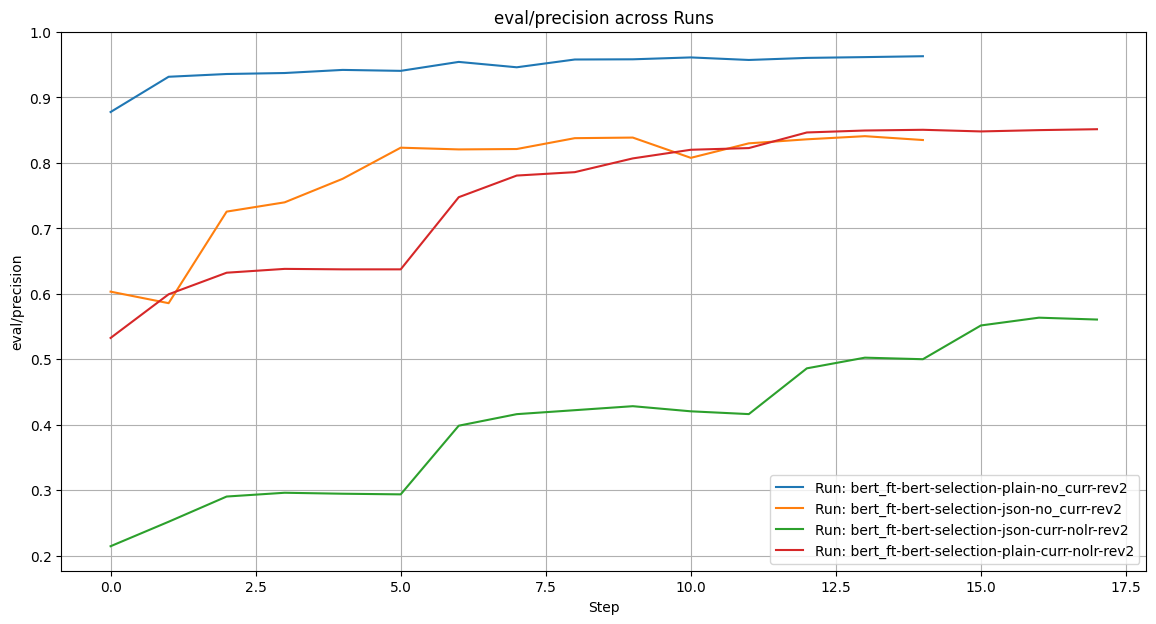

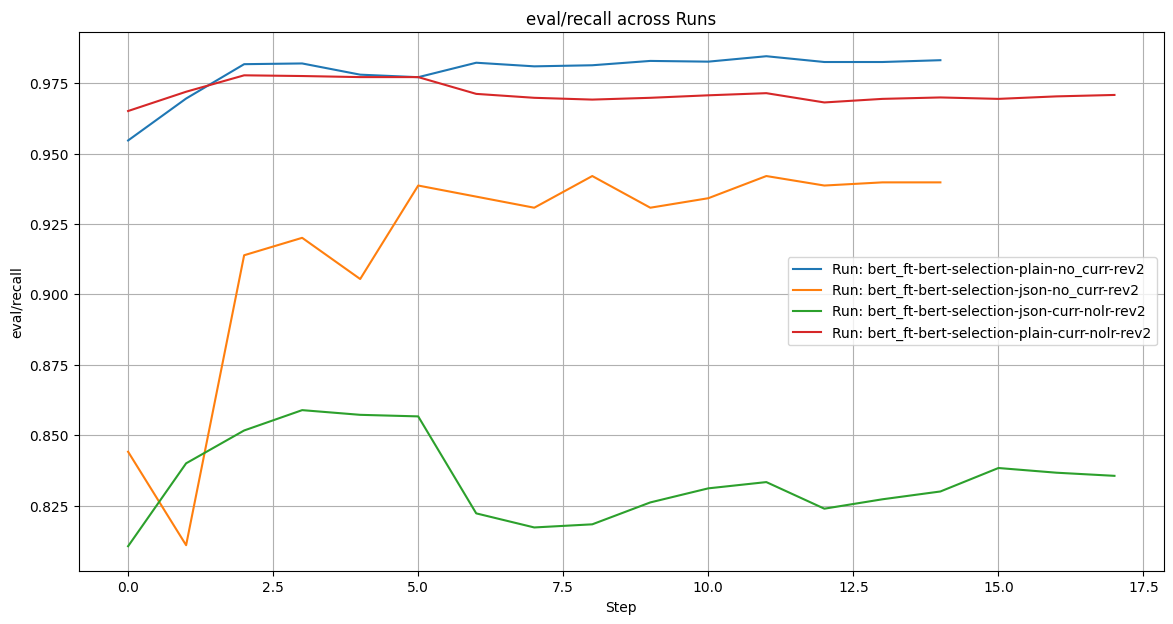

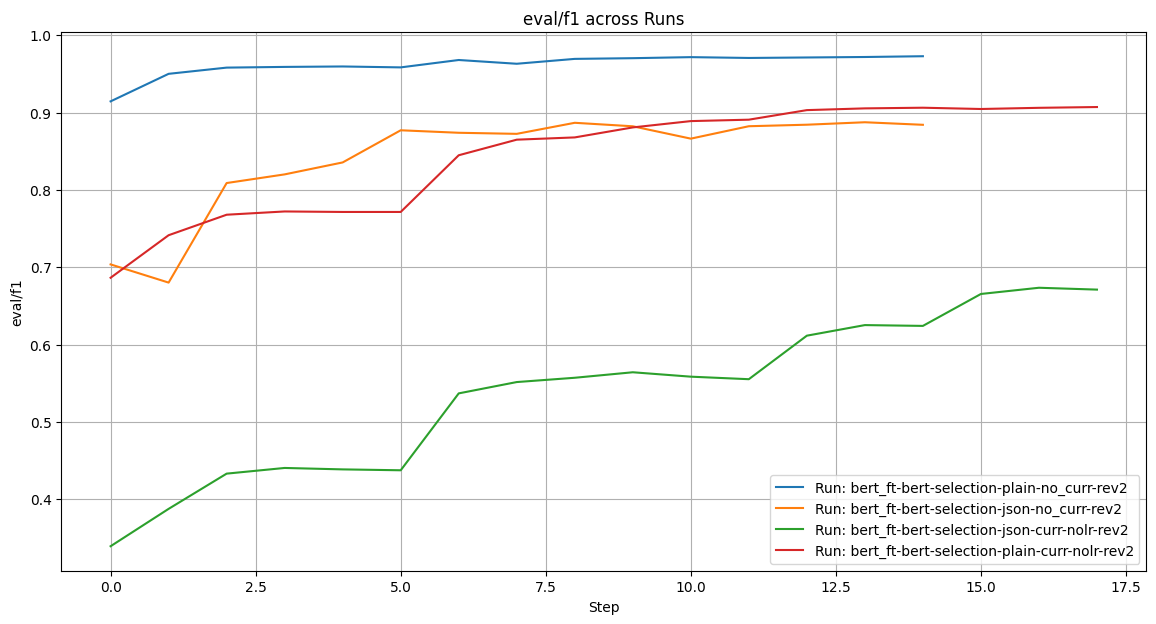

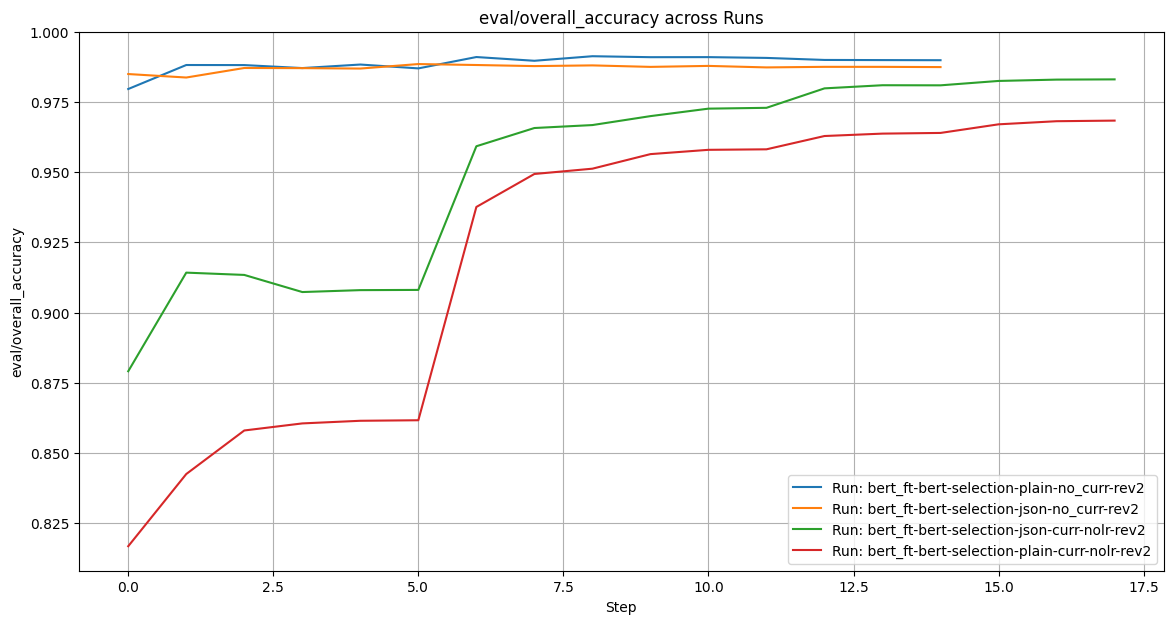

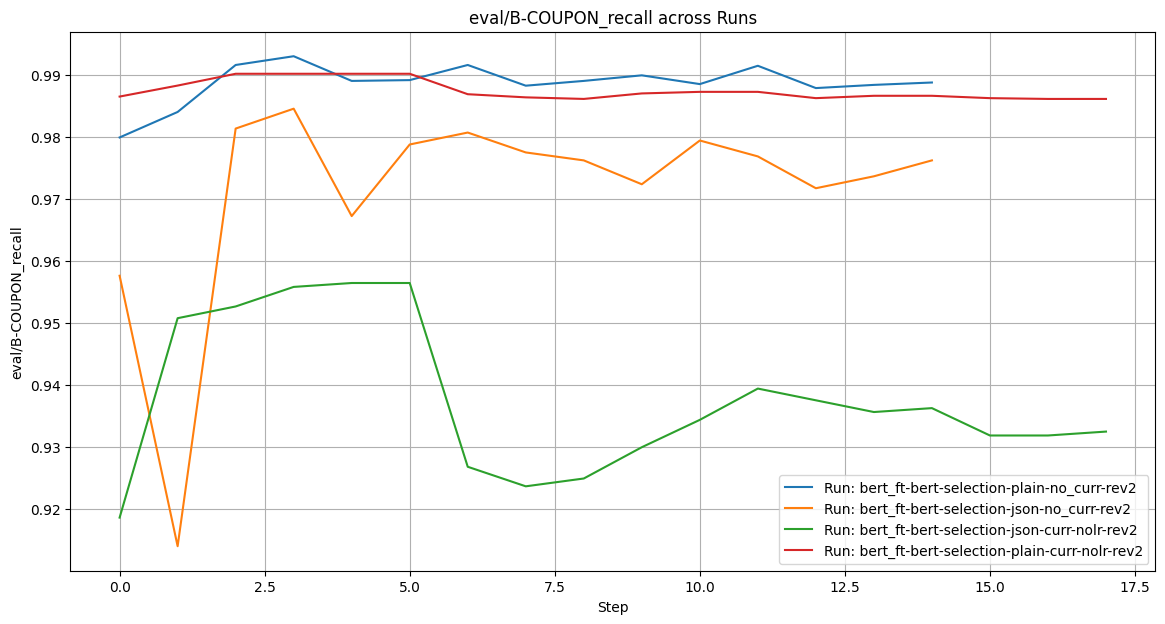

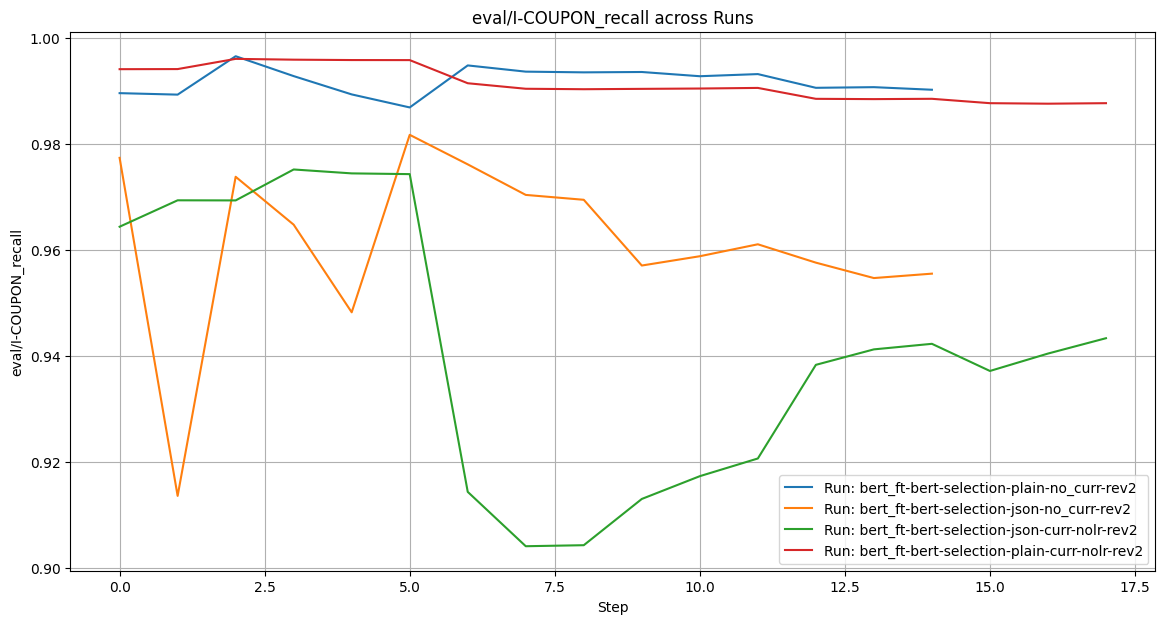

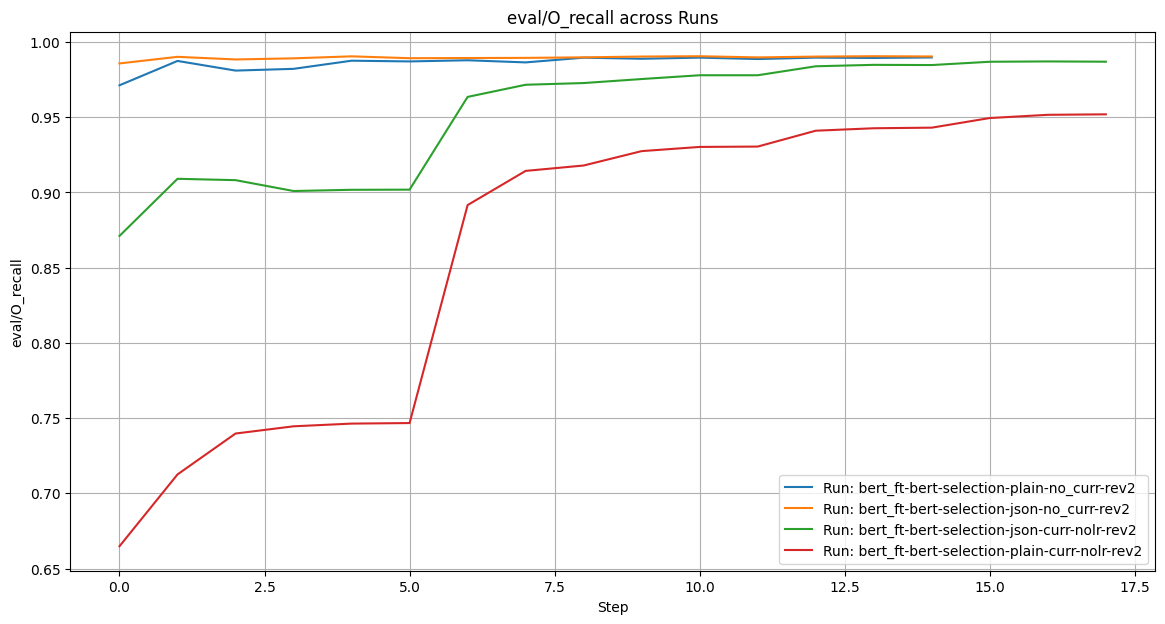

In [53]:
plot_runs_data(runs, "eval/loss")
plot_runs_data(runs, "eval/precision")
plot_runs_data(runs, "eval/recall")
plot_runs_data(runs, "eval/f1")
plot_runs_data(runs, "eval/overall_accuracy")
plot_runs_data(runs, "eval/B-COUPON_recall")
plot_runs_data(runs, "eval/I-COUPON_recall")
plot_runs_data(runs, "eval/O_recall")

## Result Summary
It seems that plain_text format performed best. Json format has lower accuracy,
which makes sense; it has a lot of additional information that may confuse the model.
Curriculum, while keeping the same relation between plain and json data, performed worse.
While it quickly reached high levels of accuracy, its low starting accuracy on eval dataset
suggests that, at least in this case, curriculum learning makes it harder for the model to learn.

What's funny, is that while the model starts to overfit very quickly, its accuracy on the eval dataset
only improves.

# Vibe check
Such high results for the plain text format are suspicious. In order to verify them, I used the code below to compare the model's predictions with the ground truth.

In [54]:
def __align_labels_with_tokens(labels: list, word_ids: list, bi_split: bool) -> list[int]:
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            if not bi_split:
                if label > 0: # If the label is not O or N/A
                    label = 2*label - 1 # Change it to B-XXX
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else: # Same word as previous token
            label = labels[word_id]
            if not bi_split:
                label = 2*label
            else: # Adjust so that one word has only one B-X token.
                if label%2 == 1: # I-X are even; Unknown is even also. B-X is odd.
                    label += 1 # from (2*label)-1 to 2*label
            new_labels.append(label)

    return new_labels

In [62]:
model = AutoModelForTokenClassification.from_pretrained("zpp-murmuras/bert-selection-plain-no_curr-rev2", token=hf_token)
dataset = load_dataset("zpp-murmuras/coupon_select_big_plain_rev2", token=hf_token)
tokenizer = AutoTokenizer.from_pretrained("zpp-murmuras/bert-selection-plain-no_curr-rev2", token=hf_token)

sample = dataset['dm']
text_input = sample["texts"][11]
label_input = sample["labels"][11]

tokenized_input = tokenizer(text_input, is_split_into_words=True, return_tensors="pt")
word_ids = tokenized_input.word_ids(batch_index=0)
prepared_labels = __align_labels_with_tokens(label_input, word_ids, True)
pred2 = model(**tokenized_input)
logits = pred2.logits
predicted_labels = torch.argmax(logits, axis=2)
total = 0
correct = 0
for a, b in zip(prepared_labels, predicted_labels[0]):
    if a == b:
        correct += 1
print(f"Accuracy: {correct/len(prepared_labels)}")

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Accuracy: 0.9864864864864865


Index 11 was chosen by me so that the example contains coupon data. It seems that our model really is able to predict the labels with high accuracy.